# 1. Install Dependencies and Setup

In [ ]:
pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(260, 370), batch_size=32)

Found 260 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 260, 370, 3)

In [13]:
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

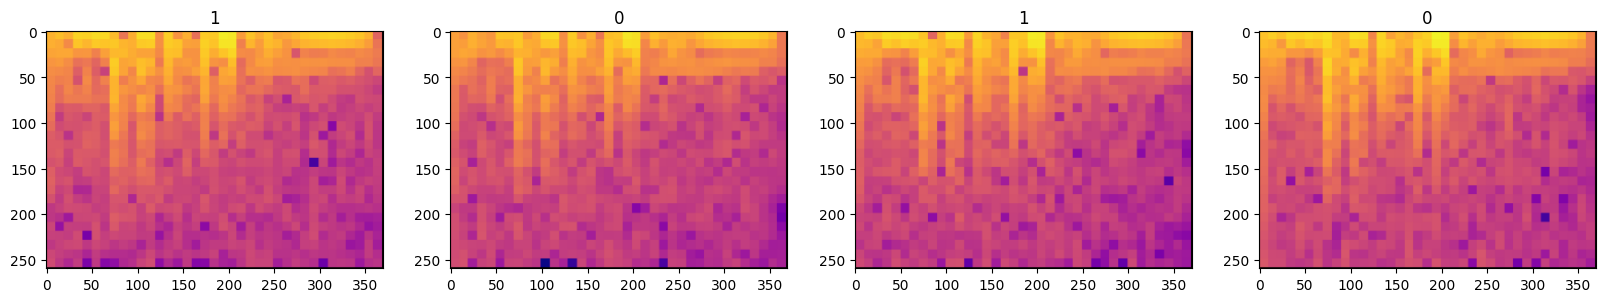

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
batch[0]

array([[[[1.80093658e+00, 1.26465762e+00, 3.28170657e-01],
         [4.79323235e+01, 3.36631966e+01, 8.74511337e+00],
         [5.05576859e+01, 3.55384560e+01, 9.30769157e+00],
         ...,
         [4.46346092e+01, 1.98846130e+01, 1.92499981e+01],
         [4.23842506e+01, 1.87594337e+01, 1.83123474e+01],
         [1.59170926e+00, 7.03871429e-01, 6.87874317e-01]],

        [[8.84969425e+00, 6.21850729e+00, 1.62338984e+00],
         [2.35473801e+02, 1.65481293e+02, 4.32443886e+01],
         [2.47884613e+02, 1.74346161e+02, 4.59038467e+01],
         ...,
         [2.19250000e+02, 9.78076935e+01, 9.48076935e+01],
         [2.08049347e+02, 9.24886627e+01, 8.98125763e+01],
         [7.81239223e+00, 3.47136641e+00, 3.37174821e+00]],

        [[9.04324913e+00, 6.35676098e+00, 1.66486597e+00],
         [2.40589188e+02, 1.69135132e+02, 4.43405418e+01],
         [2.53000000e+02, 1.78000000e+02, 4.70000000e+01],
         ...,
         [2.24000000e+02, 1.00000000e+02, 9.70000000e+01],
         [

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[1.76891983e+00, 1.05654943e+00, 4.48233098e-01],
          [4.70621567e+01, 2.81151733e+01, 1.19422026e+01],
          [4.94999924e+01, 2.96153812e+01, 1.26923065e+01],
          ...,
          [4.67499924e+01, 2.30576897e+01, 1.69230747e+01],
          [4.43121033e+01, 2.19325104e+01, 1.59854250e+01],
          [1.66369605e+00, 8.23849499e-01, 5.99890411e-01]],
 
         [[8.67432976e+00, 5.18669796e+00, 2.21497035e+00],
          [2.30797714e+02, 1.38057068e+02, 5.89925156e+01],
          [2.42884613e+02, 1.45711533e+02, 6.25384598e+01],
          ...,
          [2.29250000e+02, 1.13442307e+02, 8.31730804e+01],
          [2.17725433e+02, 1.07560684e+02, 7.87405548e+01],
          [8.17668915e+00, 4.03853559e+00, 2.95582414e+00]],
 
         [[8.85406017e+00, 5.29730082e+00, 2.27027178e+00],
          [2.35589188e+02, 1.41021622e+02, 6.04540558e+01],
          [2.48000000e+02, 1.49000000e+02, 6.40000000e+01],
          ...,
          [2.34000000e+02, 1.16000000e+02, 8.5000

# 5. Split Data

In [18]:
len(data)

9

In [19]:
9*.2

1.8

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [21]:
train_size + val_size + test_size

9

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 260, 370, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [25]:
lr = 0.0003
b1 = 0.9
b2 = 0.999
w = 0.0001

model = models.Sequential()

# Add the input layer and the first convolutional layer
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(260, 370, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add 7 more pairs of convolutional, batch norm, relu and maxpooling layers
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer to prevent overfitting
model.add(layers.Dropout(0.5))

# Add a flatten layer and a fully connected layer with 4096 neurons
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Add another dropout layer and a second fully connected layer with 4096 neurons
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Add the output layer with 1 neuron and sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential()

# Inception Module 1
model.add(Conv2D(64, (1,1), activation='relu', padding='same', input_shape=(260, 370, 3)))
model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same'))

# Inception Module 2
model.add(Conv2D(32, (1,1), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same'))

# Inception Module 3
model.add(Conv2D(16, (1,1), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same'))

# Final Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()



In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create ConvNet33 model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(260, 370, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 368, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 184, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 182, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 91, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 89, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 44, 128)      0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 52s 8s/step - loss: 609.7062 - accuracy: 0.5156 - val_loss: 19.3982 - val_accuracy: 0.5312
Epoch 2/20
6/6 [==============================] - 20s 4s/step - loss: 13.6046 - accuracy: 0.4427 - val_loss: 18.1080 - val_accuracy: 0.5000
Epoch 3/20
6/6 [==============================] - 21s 3s/step - loss: 7.7860 - accuracy: 0.4844 - val_loss: 1.5124 - val_accuracy: 0.5312
Epoch 4/20
6/6 [==============================] - 20s 3s/step - loss: 1.0395 - accuracy: 0.5104 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 21s 4s/step - loss: 0.6904 - accuracy: 0.4896 - val_loss: 0.6720 - val_accuracy: 0.5312
Epoch 6/20
6/6 [==============================] - 19s 3s/step - loss: 0.6745 - accuracy: 0.5000 - val_loss: 0.6402 - val_accuracy: 0.5156
Epoch 7/20
6/6 [==============================] - 20s 3s/step - loss: 0.6020 - accuracy: 0.7083 - val_loss: 0.5108 - val_accuracy: 0.7500
Epoch 8/20
6/6 [=============

# 8. Plot Performance

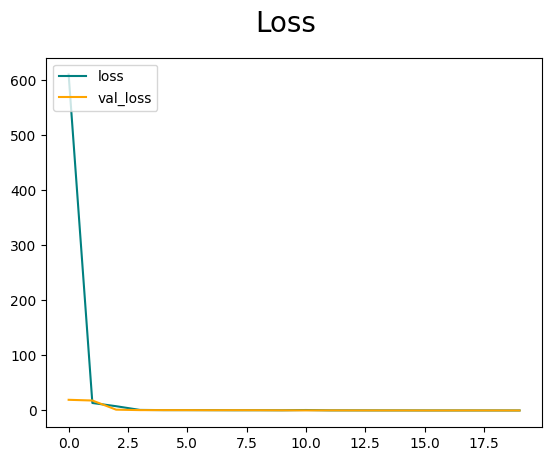

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

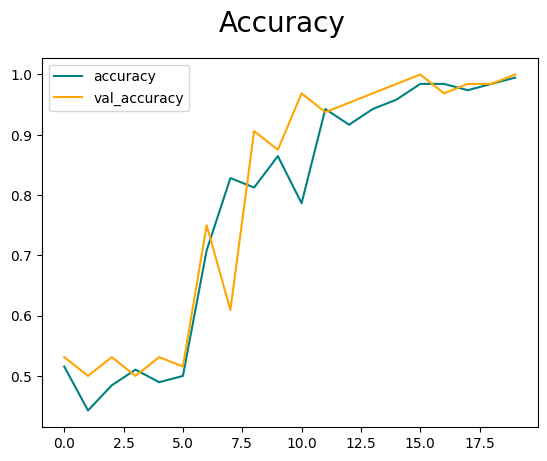

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

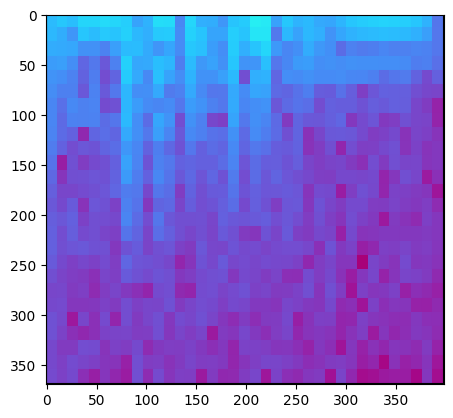

In [37]:
img = cv2.imread('./data/healthy/spectrograph_1.png')
plt.imshow(img)
plt.show()

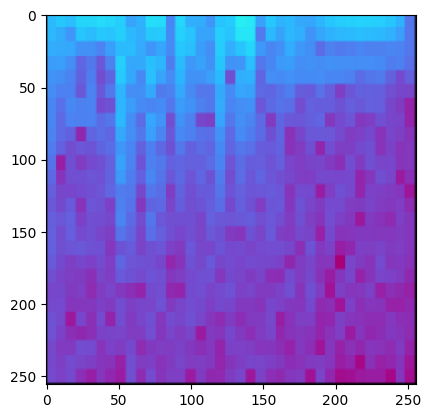

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "D:\software\Anaconda\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\software\Anaconda\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\software\Anaconda\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\software\Anaconda\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "D:\software\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\RAFROCKZZ\AppData\Local\Temp\ipykernel_10880\2554322616.py", line 1, in <module>
      yhat = model.predict(np.expand_dims(resize/255, 0))
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 115200 values, but the requested shape requires a multiple of 168960
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_3965]

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is healthy')
else:
    print(f'Predicted class is covid')

# 11. Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','imageclassifier.h5'))

In [42]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model.predict(np.expand_dims(resize/255, 0))

ValueError: in user code:

    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\STUDY\pythonstuffs\deeplearningshit\ImageClassification-main\imageclassenv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 260, 370, 3), found shape=(None, 256, 256, 3)
